In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
heart_data <- read_csv("heart_cleveland_upload.csv")

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  condition = col_double()
)



In [3]:
heart_data <- heart_data %>%
    mutate(sex = as.factor(sex),
           sex = recode(sex, "0" = "female", "1" = "male"),
          cp = as.factor(cp),
           cp = recode(cp, "0" = "typical angina",
                      "1" = "atypical angina",
                      "2" = "non-anginal pain",
                      "3" = "asymptomatic"),
           fbs = as.logical(fbs),
          restecg = as.factor(restecg),
           restecg = recode(restecg, "0" = "normal",
                           "1" = "ST-T abnormal",
                           "2" = "LVH likely"),  #left ventricular hypertrophy
           exang = as.factor(exang),
           exang = recode(exang, "0" = "no",
                          "1" = "yes"),
          slope = as.factor(slope),
           slope = recode(slope, "0" = "upsloping",
                         "1" = "flat",
                         "2" = "downsloping"),
           ca = as.factor(ca),
          thal = as.factor(thal),
           thal = recode(thal, "0" = "normal",
                        "1" = "fixed defect",
                        "2" = "reversable defect"),
          condition = as.factor(condition),
          condition = recode(condition, "0" = "no disease",
                            "1" = "disease"))
#     select(age, sex, cp, trestbps, chol, fbs, condition)
heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<lgl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
69,male,typical angina,160,234,TRUE,LVH likely,131,no,0.1,flat,1,normal,no disease
69,female,typical angina,140,239,FALSE,normal,151,no,1.8,upsloping,2,normal,no disease
66,female,typical angina,150,226,FALSE,normal,114,no,2.6,downsloping,0,normal,no disease
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,male,asymptomatic,120,198,FALSE,normal,130,yes,1.6,flat,0,reversable defect,disease
35,female,asymptomatic,138,183,FALSE,normal,182,no,1.4,upsloping,0,normal,no disease
35,male,asymptomatic,126,282,FALSE,LVH likely,156,yes,0.0,upsloping,0,reversable defect,disease


In [4]:
set.seed(2000)

heart_split <- initial_split(heart_data, prop = 0.75, strata = condition)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition,age_group
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<lgl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<chr>
69,male,typical angina,160,234,TRUE,LVH likely,131,no,0.1,flat,1,normal,no disease,old
69,female,typical angina,140,239,FALSE,normal,151,no,1.8,upsloping,2,normal,no disease,old
66,female,typical angina,150,226,FALSE,normal,114,no,2.6,downsloping,0,normal,no disease,old
65,male,typical angina,138,282,TRUE,LVH likely,174,no,1.4,flat,1,normal,disease,old
64,male,typical angina,110,211,FALSE,LVH likely,144,yes,1.8,flat,0,normal,no disease,old
64,male,typical angina,170,227,FALSE,LVH likely,155,no,0.6,flat,0,reversable defect,no disease,old


[1] 91

[1] 121

[1] 85

`summarise()` regrouping output by 'cp' (override with `.groups` argument)



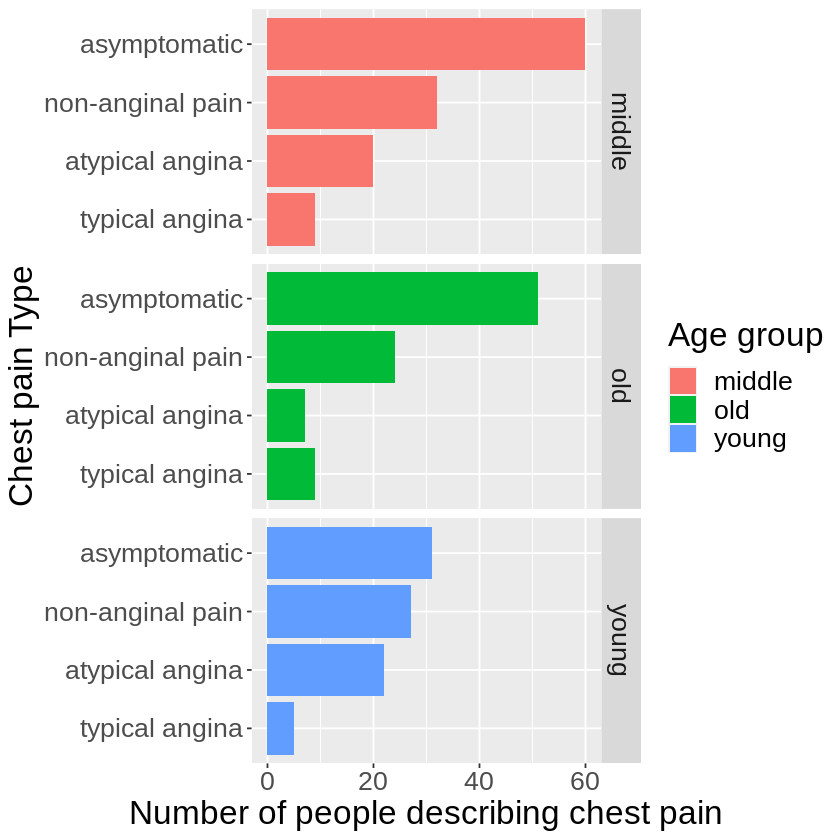

In [5]:
# 1.Divide the dataset into different age group.
heart_grouped <- within(heart_data,{
  age_group <- NA
  age_group[age>=60]="old"
  age_group[age>= 50 & age < 60] = "middle"
  age_group[age < 50] = "young"
})
head(heart_grouped)

# 2.Count the number in each group
num_old <- heart_grouped %>%
    filter(age_group == "old") %>%
    nrow()
num_old

num_middle <- heart_grouped %>%
    filter(age_group == "middle") %>%
    nrow()
num_middle

num_young <- heart_grouped %>%
    filter(age_group == "young") %>%
    nrow()
num_young

# Note: we can see that the majority of patients with 
# heart failure are between the ages of 50 and 60.

# 3.Find the differnt types of chest pain in each age group
chest_pains_age <- heart_grouped %>%
    select(cp, age_group) %>%
    group_by(cp, age_group) %>%
    summarize(count = n())

chest_pain_plot <- chest_pains_age %>%
    ggplot(aes(x = count, y = cp, fill = age_group)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_grid(age_group ~.) +
    labs(x = "Number of people describing chest pain", y = "Chest pain Type",
        fill = "Age group") +
    theme(text = element_text(size = 20))
chest_pain_plot
# 4